In [9]:
import re
import cv2
import time
import random
from tqdm import tqdm
from scipy import signal
import scipy as sp
import scipy.ndimage
import numpy as np
import typing as t
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as k
from tensorflow.keras.models import load_model, Model
from joblib import Parallel, delayed

import config as c
import utils.image_processing as ipr
import utils.model as model_factory
from utils.dataset import get_train_data, get_test_data

plt.rcParams["figure.figsize"] = (40, 40)

In [11]:
x, y = get_train_data(available_energy_values=[1, 3, 6, 10, 20, 30], input_shape=(80, 80), values_linear_transformation=False, center_by_max=False)
x = np.array(x)[:,:,:,0]
y = np.array(y)[:, 1].reshape((-1, 1)).astype(np.float)

100%|██████████| 6646/6646 [00:00<00:00, 42062.98it/s]


In [18]:
#plt.imshow(x[1])

In [19]:
def create_circular_mask(h, w, center=None, radius=None):
    if center is None:
        center = (int(w/2), int(h/2))
    if radius is None:
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

def get_matrix(img):
    m = np.zeros((40))
    for r in range(0, 40):
        mask = create_circular_mask(80, 80, radius=r) * (~create_circular_mask(80, 80, radius=r-1))
        m[r] = np.sum(mask * img) / np.sum(mask)
    return m

def get_img_spector(img):
    m = img-100
    m = sp.ndimage.filters.gaussian_filter(m, [2.0, 2.0])
    m = get_matrix(m)
    return m

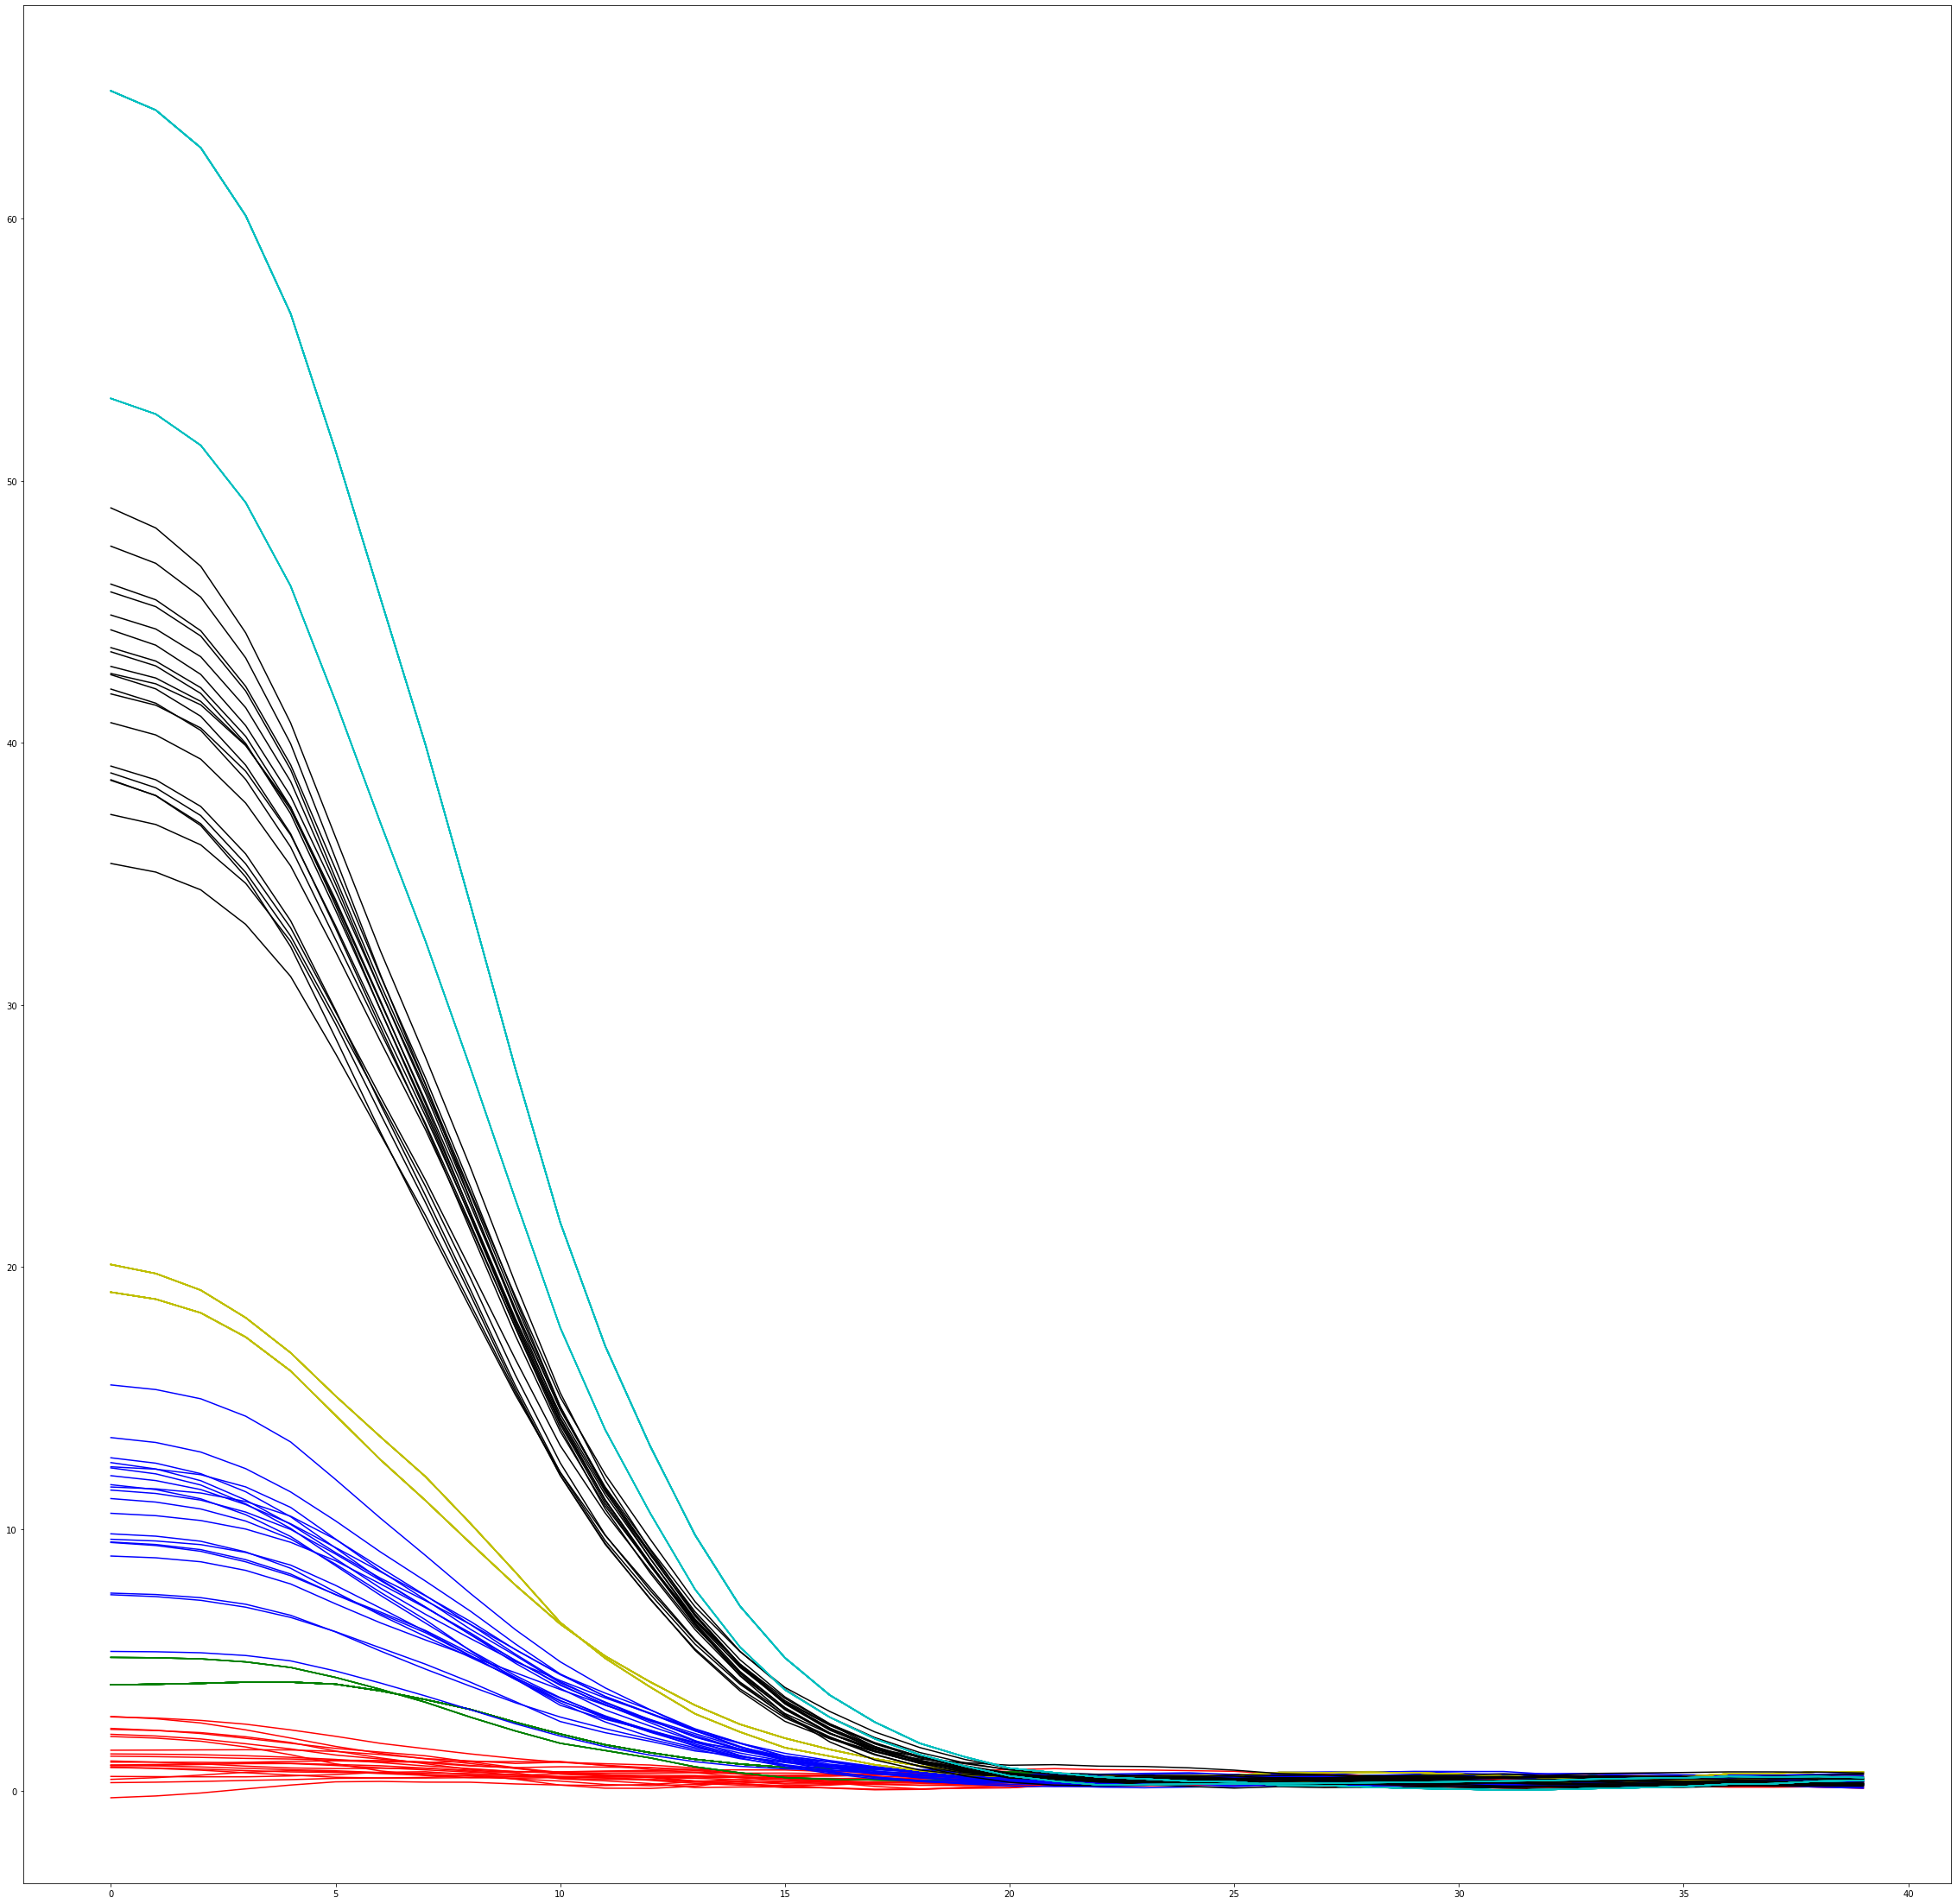

In [21]:
energys = [1, 3, 6, 10, 20, 30]
colors = ['r', 'g', 'b', 'y', 'k', 'c']
for i in range(6):
    energy = energys[i]
    color = colors[i]
    for j in range(20):
        spector = get_img_spector(random.choice(x[y.reshape(-1)==energy]))
        #spector /= max(spector)
        plt.plot(spector, color=color)
plt.plot()
plt.show()